# Restaurant Menu Complexity: Exploratory Data Analysis

## Objectives
1. Deep dive into treatment and outcome variables
2. Identify potential confounders (variables that affect both treatment and outcome)
3. Check covariate balance between treatment groups
4. Visualize relationships and patterns
5. Test naive correlations before causal analysis

## Why This Matters for Causal Inference
Before we can estimate causal effects, we need to:
- Understand what makes restaurants choose simple vs complex menus (treatment assignment)
- Identify variables that could bias our estimates if not controlled
- Check if treatment groups are comparable on observables

---


In [14]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['text.usetex'] = False  # Prevent LaTeX errors

print("Imports loaded")

Imports loaded


In [15]:
# Cell 2: Load Feature-Engineered Data
print("Loading feature-engineered data...")

df = pd.read_csv('data/processed/restaurants_with_features.csv')

print(f"Loaded {len(df):,} restaurants")
print(f"Features: {len(df.columns)}")
print(f"\nDataset shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())

Loading feature-engineered data...
Loaded 17,625 restaurants
Features: 27

Dataset shape: (17625, 27)

Column names:
['business_id', 'name', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'complex_menu', 'menu_complexity_score', 'primary_cuisine', 'category_count', 'price_imputed', 'is_open', 'mentions_extensive', 'mentions_limited', 'mentions_variety', 'net_complexity_signal', 'RestaurantsPriceRange2', 'RestaurantsGoodForGroups', 'RestaurantsTakeOut', 'RestaurantsDelivery', 'RestaurantsReservations', 'Caters', 'categories', 'attributes']


OUTCOME VARIABLE: Restaurant Rating (Stars)

Rating distribution:
count    17625.000
mean         3.744
std          0.720
min          1.000
25%          3.500
50%          4.000
75%          4.500
max          5.000
Name: stars, dtype: float64

Rating value counts:
1.0       9
1.5     160
2.0     509
2.5    1140
3.0    2075
3.5    3771
4.0    5350
4.5    4030
5.0     581
Name: stars, dtype: int64


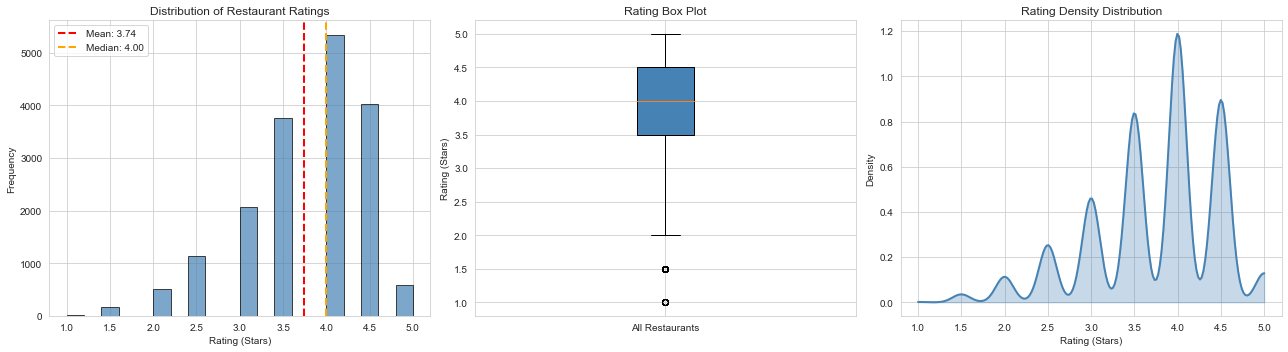


Outliers (IQR method): 169 restaurants (0.96%)


In [16]:
# Cell 3: Outcome Variable Analysis
print("="*60)
print("OUTCOME VARIABLE: Restaurant Rating (Stars)")
print("="*60)

print("\nRating distribution:")
print(df['stars'].describe())

print("\nRating value counts:")
print(df['stars'].value_counts().sort_index())

# Visualize outcome
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df['stars'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df['stars'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {df["stars"].mean():.2f}')
axes[0].axvline(df['stars'].median(), color='orange', linestyle='--', 
                linewidth=2, label=f'Median: {df["stars"].median():.2f}')
axes[0].set_xlabel('Rating (Stars)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Restaurant Ratings')
axes[0].legend()

# Box plot
bp = axes[1].boxplot(df['stars'], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
axes[1].set_ylabel('Rating (Stars)')
axes[1].set_title('Rating Box Plot')
axes[1].set_xticklabels(['All Restaurants'])

# KDE plot
from scipy.stats import gaussian_kde
density = gaussian_kde(df['stars'])
xs = np.linspace(df['stars'].min(), df['stars'].max(), 200)
axes[2].plot(xs, density(xs), linewidth=2, color='steelblue')
axes[2].fill_between(xs, 0, density(xs), alpha=0.3, color='steelblue')
axes[2].set_xlabel('Rating (Stars)')
axes[2].set_ylabel('Density')
axes[2].set_title('Rating Density Distribution')

plt.tight_layout()
plt.savefig('outputs/figures/outcome_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Check for outliers
q1 = df['stars'].quantile(0.25)
q3 = df['stars'].quantile(0.75)
iqr = q3 - q1
outliers = df[(df['stars'] < q1 - 1.5*iqr) | (df['stars'] > q3 + 1.5*iqr)]
print(f"\nOutliers (IQR method): {len(outliers)} restaurants ({len(outliers)/len(df)*100:.2f}%)")

TREATMENT VARIABLE: Menu Complexity

Treatment distribution:
0    8893
1    8732
Name: complex_menu, dtype: int64

Simple menus: 8,893 (50.5%)
Complex menus: 8,732 (49.5%)

Complexity score by treatment:
               count    mean    std   min   25%   50%   75%   max
complex_menu                                                     
0             8893.0  19.429  3.547   8.0  17.0  20.0  22.5  24.5
1             8732.0  30.881  5.024  25.0  27.0  30.0  33.0  52.0


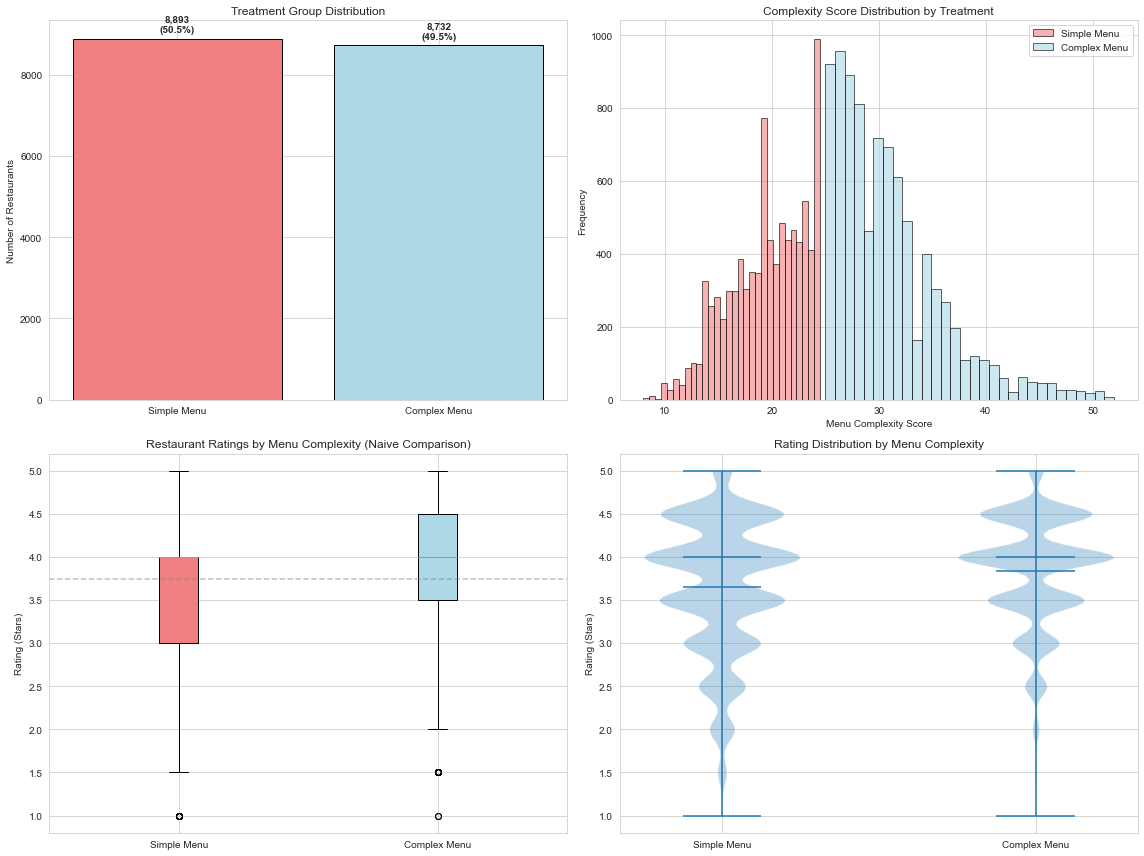


NAIVE COMPARISON (NOT CAUSAL - CONFOUNDERS NOT CONTROLLED)

Simple menu avg rating: 3.651 (std: 0.780)
Complex menu avg rating: 3.838 (std: 0.639)
Difference: -0.187 stars

T-test: t=-17.365, p=0.0000
Result: Statistically significant difference (but NOT necessarily causal!)
Cohen's d (effect size): -0.262


In [17]:
# Cell 4: Treatment Variable Analysis
print("="*60)
print("TREATMENT VARIABLE: Menu Complexity")
print("="*60)

print("\nTreatment distribution:")
treatment_dist = df['complex_menu'].value_counts().sort_index()
print(treatment_dist)
print(f"\nSimple menus: {treatment_dist[0]:,} ({treatment_dist[0]/len(df)*100:.1f}%)")
print(f"Complex menus: {treatment_dist[1]:,} ({treatment_dist[1]/len(df)*100:.1f}%)")

print("\nComplexity score by treatment:")
print(df.groupby('complex_menu')['menu_complexity_score'].describe())

# Visualize treatment
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Treatment distribution
axes[0, 0].bar(['Simple Menu', 'Complex Menu'], 
               [treatment_dist[0], treatment_dist[1]],
               color=['lightcoral', 'lightblue'], edgecolor='black')
axes[0, 0].set_ylabel('Number of Restaurants')
axes[0, 0].set_title('Treatment Group Distribution')
for i, v in enumerate([treatment_dist[0], treatment_dist[1]]):
    axes[0, 0].text(i, v + 100, f'{v:,}\n({v/len(df)*100:.1f}%)', 
                    ha='center', va='bottom', fontweight='bold')

# Complexity score distribution by treatment
df[df['complex_menu']==0]['menu_complexity_score'].hist(
    bins=30, alpha=0.6, label='Simple Menu', ax=axes[0, 1], color='lightcoral', edgecolor='black')
df[df['complex_menu']==1]['menu_complexity_score'].hist(
    bins=30, alpha=0.6, label='Complex Menu', ax=axes[0, 1], color='lightblue', edgecolor='black')
axes[0, 1].set_xlabel('Menu Complexity Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Complexity Score Distribution by Treatment')
axes[0, 1].legend()

# Box plot: Rating by treatment (MAIN COMPARISON)
bp = axes[1, 0].boxplot([df[df['complex_menu']==0]['stars'],
                          df[df['complex_menu']==1]['stars']],
                         labels=['Simple Menu', 'Complex Menu'],
                         patch_artist=True)
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][1].set_facecolor('lightblue')
axes[1, 0].set_ylabel('Rating (Stars)')
axes[1, 0].set_title('Restaurant Ratings by Menu Complexity (Naive Comparison)')
axes[1, 0].axhline(df['stars'].mean(), color='gray', linestyle='--', alpha=0.5)

# Violin plot: Rating by treatment
parts = axes[1, 1].violinplot([df[df['complex_menu']==0]['stars'],
                                df[df['complex_menu']==1]['stars']],
                               positions=[0, 1], showmeans=True, showmedians=True)
axes[1, 1].set_ylabel('Rating (Stars)')
axes[1, 1].set_title('Rating Distribution by Menu Complexity')
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['Simple Menu', 'Complex Menu'])

plt.tight_layout()
plt.savefig('outputs/figures/treatment_outcome_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical test (naive, not causal)
simple_ratings = df[df['complex_menu']==0]['stars']
complex_ratings = df[df['complex_menu']==1]['stars']

print("\n" + "="*60)
print("NAIVE COMPARISON (NOT CAUSAL - CONFOUNDERS NOT CONTROLLED)")
print("="*60)
print(f"\nSimple menu avg rating: {simple_ratings.mean():.3f} (std: {simple_ratings.std():.3f})")
print(f"Complex menu avg rating: {complex_ratings.mean():.3f} (std: {complex_ratings.std():.3f})")
print(f"Difference: {simple_ratings.mean() - complex_ratings.mean():.3f} stars")

# T-test
t_stat, p_value = stats.ttest_ind(simple_ratings, complex_ratings)
print(f"\nT-test: t={t_stat:.3f}, p={p_value:.4f}")
if p_value < 0.05:
    print("Result: Statistically significant difference (but NOT necessarily causal!)")
else:
    print("Result: No statistically significant difference")

# Effect size (Cohen's d)
cohens_d = (simple_ratings.mean() - complex_ratings.mean()) / np.sqrt(
    ((len(simple_ratings)-1)*simple_ratings.std()**2 + 
     (len(complex_ratings)-1)*complex_ratings.std()**2) / 
    (len(simple_ratings) + len(complex_ratings) - 2)
)
print(f"Cohen's d (effect size): {cohens_d:.3f}")

In [18]:
# Cell 5: Identify Potential Confounders
print("="*60)
print("POTENTIAL CONFOUNDERS")
print("="*60)
print("\nConfounders are variables that affect BOTH:")
print("1. Treatment assignment (why restaurants choose simple/complex menus)")
print("2. Outcome (restaurant ratings)")
print("\nKey potential confounders to investigate:")

confounders = {
    'Cuisine Type': 'primary_cuisine',
    'Price Range': 'price_imputed',
    'City/Location': 'city',
    'Review Count': 'review_count',
    'Category Diversity': 'category_count'
}

for name, col in confounders.items():
    print(f"  • {name} ({col})")

POTENTIAL CONFOUNDERS

Confounders are variables that affect BOTH:
1. Treatment assignment (why restaurants choose simple/complex menus)
2. Outcome (restaurant ratings)

Key potential confounders to investigate:
  • Cuisine Type (primary_cuisine)
  • Price Range (price_imputed)
  • City/Location (city)
  • Review Count (review_count)
  • Category Diversity (category_count)



CONFOUNDER 1: Cuisine Type

Cuisine distribution by treatment (% within cuisine):
complex_menu           0       1
primary_cuisine                 
Indian            19.863  80.137
Tapas             25.000  75.000
Mediterranean     26.786  73.214
American          28.276  71.724
French            28.571  71.429
Italian           33.390  66.610
Middle Eastern    35.849  64.151
Sandwiches        39.703  60.297
Thai              41.311  58.689
Breakfast/Brunch  44.198  55.802
Seafood           47.059  52.941
Japanese          49.010  50.990
Steakhouses       50.602  49.398
Korean            51.685  48.315
Vietnamese        51.953  48.047

Average rating by cuisine (min 50 restaurants):
                   mean  count
primary_cuisine               
Middle Eastern    4.245     53
French            4.147    112
Mediterranean     4.101    336
Korean            4.084     89
Thai              4.066    305
Greek             4.021    119
Vietnamese        4.008    256
Indian            3.993    2

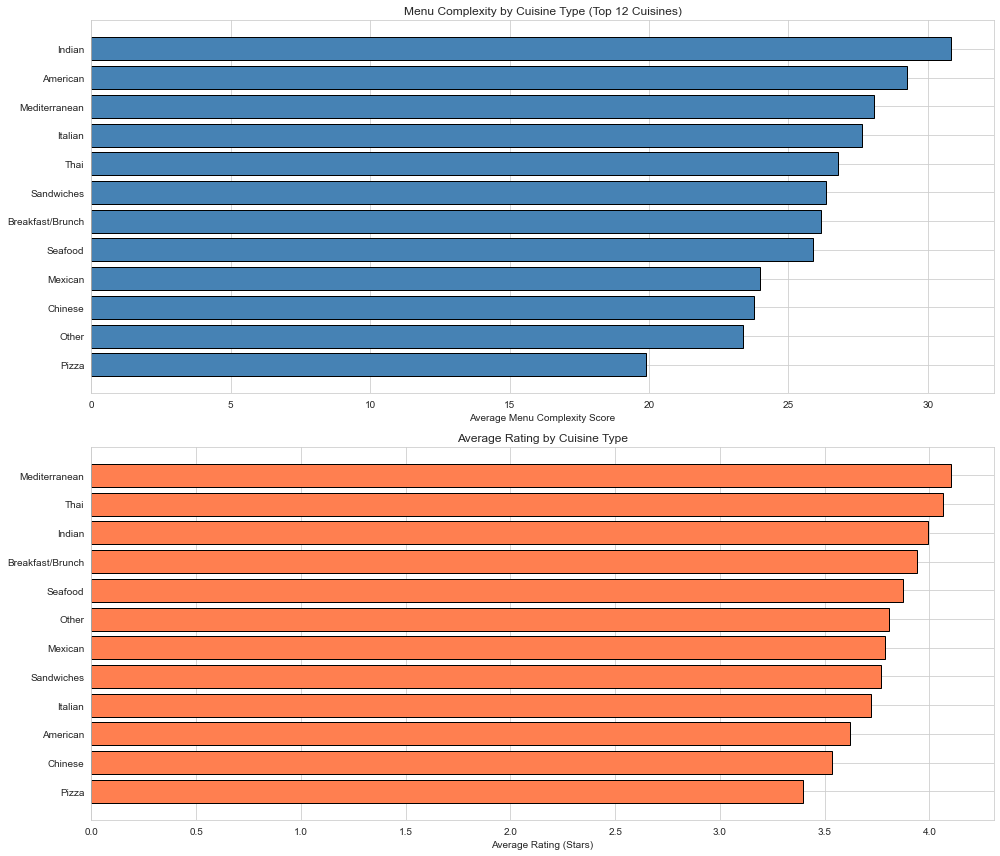


Cuisine is a confounder: Different cuisines have different complexity AND ratings


In [19]:
# Cell 6: Confounder Analysis - Cuisine Type
print("\n" + "="*60)
print("CONFOUNDER 1: Cuisine Type")
print("="*60)

# Cuisine distribution by treatment
cuisine_treatment = pd.crosstab(df['primary_cuisine'], df['complex_menu'], normalize='index') * 100
print("\nCuisine distribution by treatment (% within cuisine):")
print(cuisine_treatment.sort_values(1, ascending=False).head(15))

# Average rating by cuisine
cuisine_ratings = df.groupby('primary_cuisine')['stars'].agg(['mean', 'count'])
cuisine_ratings = cuisine_ratings[cuisine_ratings['count'] >= 50].sort_values('mean', ascending=False)
print("\nAverage rating by cuisine (min 50 restaurants):")
print(cuisine_ratings.head(15))

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Top cuisines: complexity score
top_cuisines = df['primary_cuisine'].value_counts().head(12).index
cuisine_data = df[df['primary_cuisine'].isin(top_cuisines)]

cuisine_complexity = cuisine_data.groupby('primary_cuisine').agg({
    'menu_complexity_score': 'mean',
    'stars': 'mean',
    'business_id': 'count'
}).sort_values('menu_complexity_score', ascending=False)

axes[0].barh(range(len(cuisine_complexity)), cuisine_complexity['menu_complexity_score'],
             color='steelblue', edgecolor='black')
axes[0].set_yticks(range(len(cuisine_complexity)))
axes[0].set_yticklabels(cuisine_complexity.index)
axes[0].set_xlabel('Average Menu Complexity Score')
axes[0].set_title('Menu Complexity by Cuisine Type (Top 12 Cuisines)')
axes[0].invert_yaxis()

# Rating by cuisine
cuisine_complexity_sorted = cuisine_complexity.sort_values('stars', ascending=False)
axes[1].barh(range(len(cuisine_complexity_sorted)), cuisine_complexity_sorted['stars'],
             color='coral', edgecolor='black')
axes[1].set_yticks(range(len(cuisine_complexity_sorted)))
axes[1].set_yticklabels(cuisine_complexity_sorted.index)
axes[1].set_xlabel('Average Rating (Stars)')
axes[1].set_title('Average Rating by Cuisine Type')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('outputs/figures/confounder_cuisine.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCuisine is a confounder: Different cuisines have different complexity AND ratings")


CONFOUNDER 2: Price Range

Price distribution by treatment:
               count   mean    std  min  25%  50%  75%  max
complex_menu                                               
0             8893.0  1.463  0.524  1.0  1.0  1.0  2.0  4.0
1             8732.0  1.818  0.532  1.0  2.0  2.0  2.0  4.0

Statistics by price range:
               stars               menu_complexity_score complex_menu
                mean    std  count                  mean     <lambda>
price_imputed                                                        
1.0            3.690  0.778   7004                21.808         2122
2.0            3.777  0.680  10039                27.111         6135
3.0            3.806  0.590    525                29.788          421
4.0            3.947  0.736     57                33.044           54


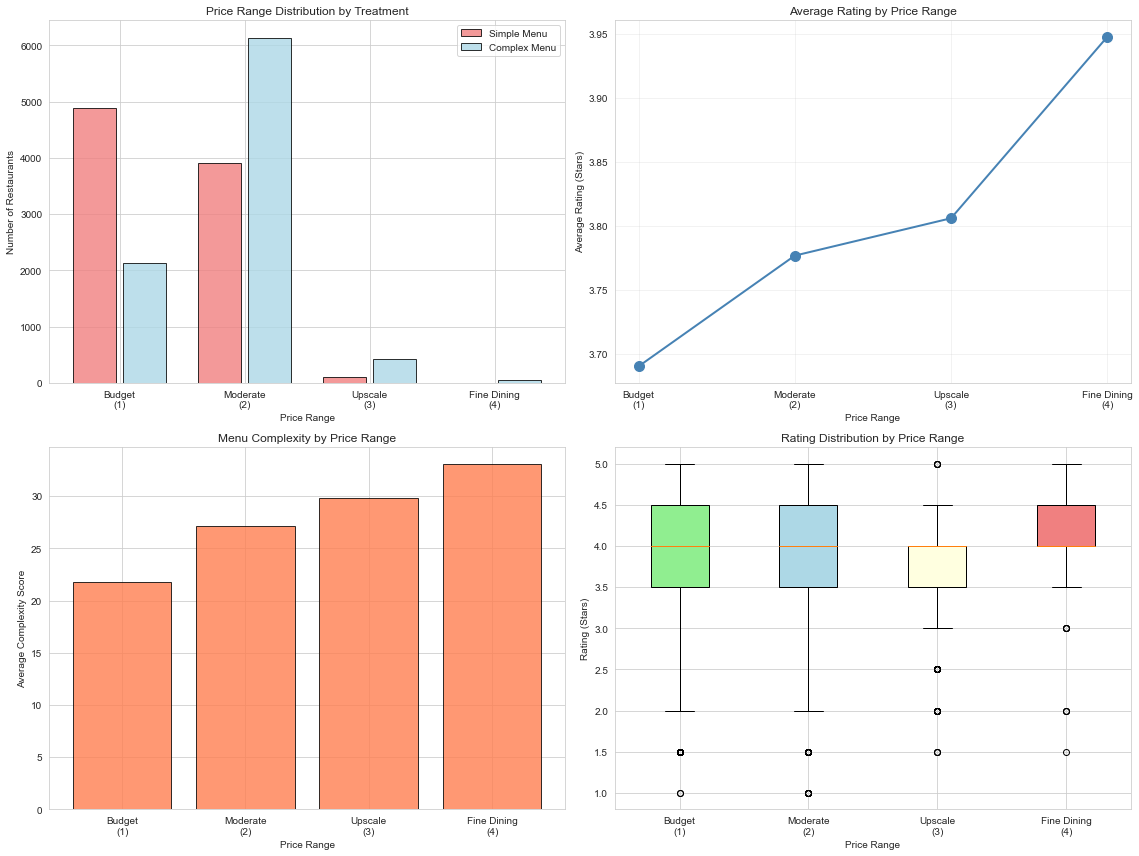


Price is a confounder: Higher prices correlate with complexity AND ratings


In [20]:
# Cell 7: Confounder Analysis - Price Range
print("\n" + "="*60)
print("CONFOUNDER 2: Price Range")
print("="*60)

# Price distribution by treatment
price_treatment = df.groupby('complex_menu')['price_imputed'].describe()
print("\nPrice distribution by treatment:")
print(price_treatment)

# Price vs rating
price_stats = df.groupby('price_imputed').agg({
    'stars': ['mean', 'std', 'count'],
    'menu_complexity_score': 'mean',
    'complex_menu': lambda x: (x==1).sum()
})
print("\nStatistics by price range:")
print(price_stats)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Price distribution by treatment
price_labels = ['Budget\n(1)', 'Moderate\n(2)', 'Upscale\n(3)', 'Fine Dining\n(4)']
for treatment, color, label in [(0, 'lightcoral', 'Simple Menu'), 
                                 (1, 'lightblue', 'Complex Menu')]:
    price_dist = df[df['complex_menu']==treatment]['price_imputed'].value_counts().sort_index()
    axes[0, 0].bar(price_dist.index + (0.2 if treatment else -0.2), 
                   price_dist.values, width=0.35, label=label, 
                   color=color, edgecolor='black', alpha=0.8)

axes[0, 0].set_xlabel('Price Range')
axes[0, 0].set_ylabel('Number of Restaurants')
axes[0, 0].set_title('Price Range Distribution by Treatment')
axes[0, 0].set_xticks([1, 2, 3, 4])
axes[0, 0].set_xticklabels(price_labels)
axes[0, 0].legend()

# Rating by price
price_ratings = df.groupby('price_imputed')['stars'].mean()
axes[0, 1].plot(price_ratings.index, price_ratings.values, 
                marker='o', linewidth=2, markersize=10, color='steelblue')
axes[0, 1].set_xlabel('Price Range')
axes[0, 1].set_ylabel('Average Rating (Stars)')
axes[0, 1].set_title('Average Rating by Price Range')
axes[0, 1].set_xticks([1, 2, 3, 4])
axes[0, 1].set_xticklabels(price_labels)
axes[0, 1].grid(True, alpha=0.3)

# Complexity by price
price_complexity = df.groupby('price_imputed')['menu_complexity_score'].mean()
axes[1, 0].bar(price_complexity.index, price_complexity.values, 
               color='coral', edgecolor='black', alpha=0.8)
axes[1, 0].set_xlabel('Price Range')
axes[1, 0].set_ylabel('Average Complexity Score')
axes[1, 0].set_title('Menu Complexity by Price Range')
axes[1, 0].set_xticks([1, 2, 3, 4])
axes[1, 0].set_xticklabels(price_labels)

# Box plot: Rating by price
price_data = [df[df['price_imputed']==p]['stars'] for p in [1, 2, 3, 4]]
bp = axes[1, 1].boxplot(price_data, labels=price_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightgreen', 'lightblue', 'lightyellow', 'lightcoral']):
    patch.set_facecolor(color)
axes[1, 1].set_xlabel('Price Range')
axes[1, 1].set_ylabel('Rating (Stars)')
axes[1, 1].set_title('Rating Distribution by Price Range')

plt.tight_layout()
plt.savefig('outputs/figures/confounder_price.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPrice is a confounder: Higher prices correlate with complexity AND ratings")


CONFOUNDER 3: Geographic Location (City)

Top 10 cities statistics:
               avg_rating  rating_std  avg_complexity  pct_complex  count
city                                                                     
Santa Barbara       3.977       0.679          26.741       60.185    324
New Orleans         3.942       0.631          26.364       54.843    795
Indianapolis        3.848       0.740          25.800       50.605    909
Tampa               3.821       0.703          26.020       55.321    949
Edmonton            3.799       0.590          25.218       50.000    518
Philadelphia        3.769       0.721          25.120       48.634   1830
Nashville           3.741       0.814          24.836       47.030    808
Saint Louis         3.734       0.741          24.921       48.303    501
Reno                3.732       0.734          26.723       56.212    491
Tucson              3.660       0.726          25.341       50.529    851


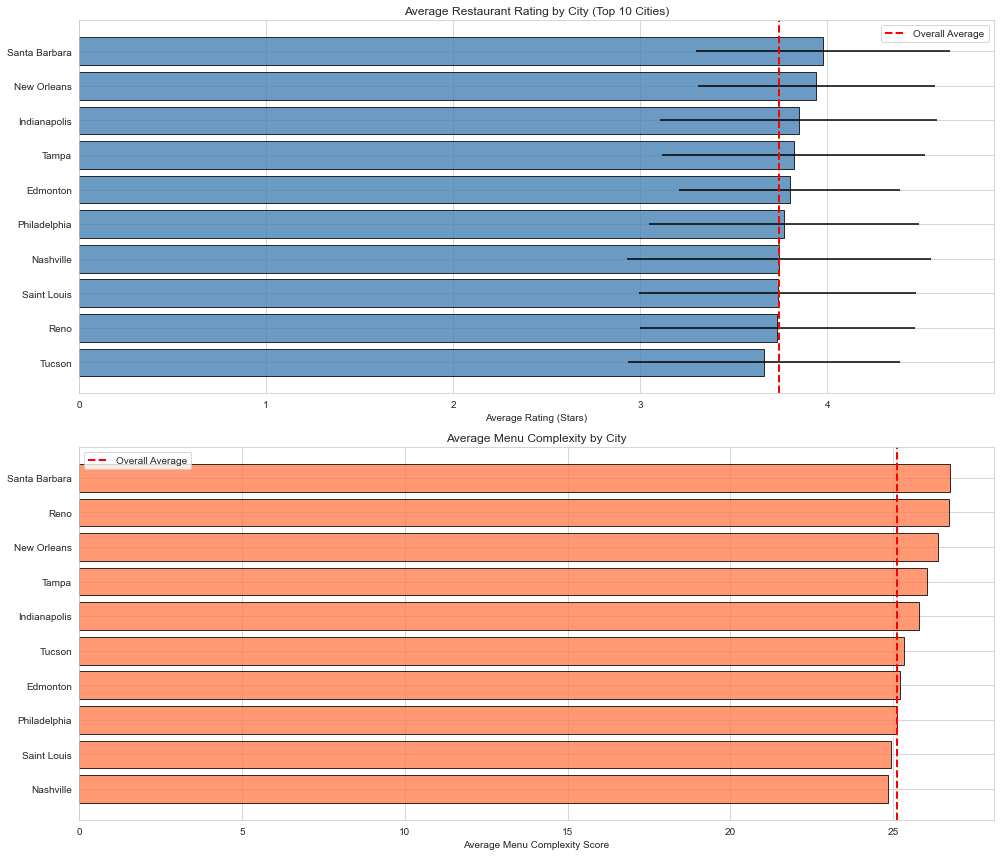


Geography is a confounder: Cities differ in both complexity and ratings


In [21]:
# Cell 8: Confounder Analysis - Geography (City)
print("\n" + "="*60)
print("CONFOUNDER 3: Geographic Location (City)")
print("="*60)

# Top cities
top_cities = df['city'].value_counts().head(10).index
city_data = df[df['city'].isin(top_cities)]

city_stats = city_data.groupby('city').agg({
    'stars': ['mean', 'std'],
    'menu_complexity_score': 'mean',
    'complex_menu': lambda x: (x==1).mean() * 100,  # % complex
    'business_id': 'count'
}).round(3)

city_stats.columns = ['avg_rating', 'rating_std', 'avg_complexity', 'pct_complex', 'count']
city_stats = city_stats.sort_values('avg_rating', ascending=False)

print("\nTop 10 cities statistics:")
print(city_stats)

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Rating by city
city_ratings = city_stats.sort_values('avg_rating', ascending=True)
axes[0].barh(range(len(city_ratings)), city_ratings['avg_rating'], 
             xerr=city_ratings['rating_std'], color='steelblue', 
             edgecolor='black', alpha=0.8)
axes[0].set_yticks(range(len(city_ratings)))
axes[0].set_yticklabels(city_ratings.index)
axes[0].set_xlabel('Average Rating (Stars)')
axes[0].set_title('Average Restaurant Rating by City (Top 10 Cities)')
axes[0].axvline(df['stars'].mean(), color='red', linestyle='--', 
                linewidth=2, label='Overall Average')
axes[0].legend()

# Complexity by city
city_complexity = city_stats.sort_values('avg_complexity', ascending=True)
axes[1].barh(range(len(city_complexity)), city_complexity['avg_complexity'],
             color='coral', edgecolor='black', alpha=0.8)
axes[1].set_yticks(range(len(city_complexity)))
axes[1].set_yticklabels(city_complexity.index)
axes[1].set_xlabel('Average Menu Complexity Score')
axes[1].set_title('Average Menu Complexity by City')
axes[1].axvline(df['menu_complexity_score'].mean(), color='red', 
                linestyle='--', linewidth=2, label='Overall Average')
axes[1].legend()

plt.tight_layout()
plt.savefig('outputs/figures/confounder_geography.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGeography is a confounder: Cities differ in both complexity and ratings")


CONFOUNDER 4: Review Count (Restaurant Popularity)

Statistics by review count:
             avg_rating  rating_std  count  avg_complexity  pct_complex
review_bins                                                            
20-50             3.593       0.812   7423          21.512       28.748
51-100            3.749       0.699   4536          24.910       50.507
101-200           3.880       0.581   3095          28.028       69.596
201-500           3.989       0.480   1981          31.550       83.190
500+              4.057       0.431    590          34.765       85.593

Correlation: Review Count vs Rating: 0.124
Correlation: Review Count vs Complexity: 0.351


KeyboardInterrupt: 

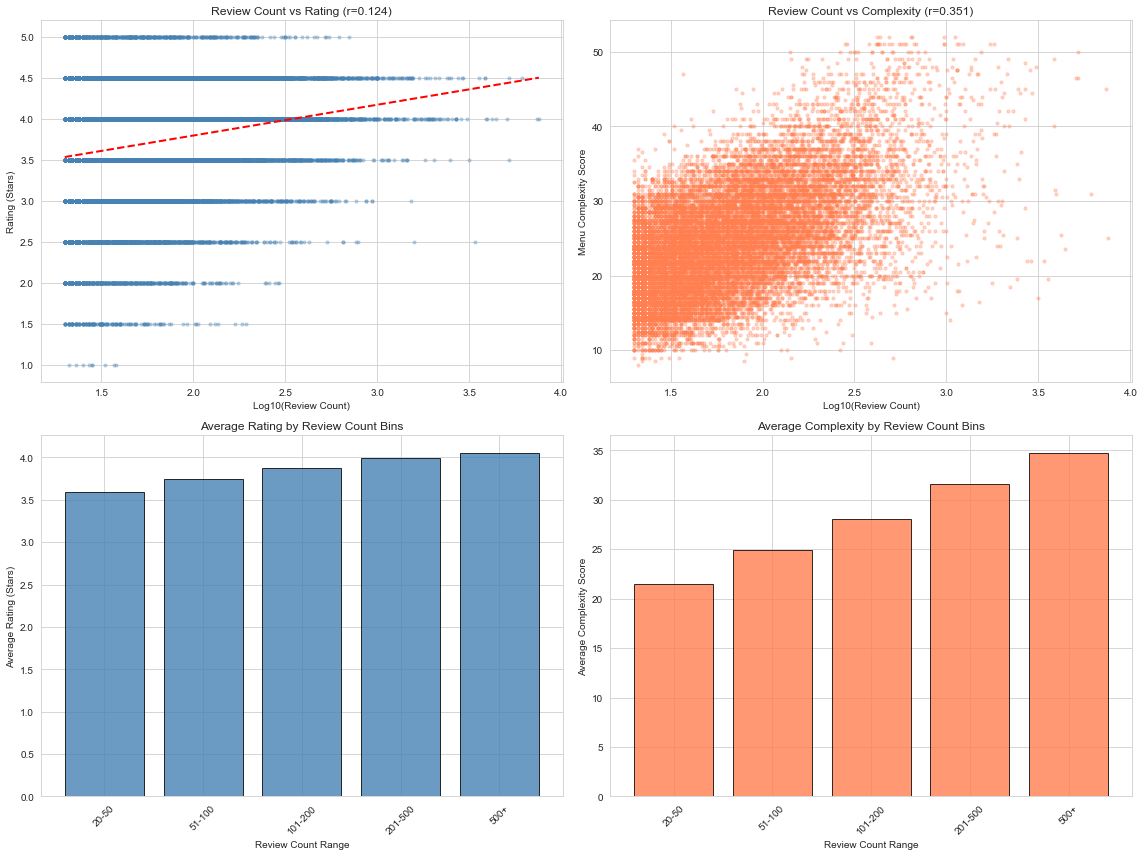

In [22]:
# Cell 9: Confounder Analysis - Review Count (Popularity)
print("\n" + "="*60)
print("CONFOUNDER 4: Review Count (Restaurant Popularity)")
print("="*60)

# Create review count bins
df['review_bins'] = pd.cut(df['review_count'], 
                           bins=[0, 50, 100, 200, 500, 10000],
                           labels=['20-50', '51-100', '101-200', '201-500', '500+'])

review_stats = df.groupby('review_bins').agg({
    'stars': ['mean', 'std', 'count'],
    'menu_complexity_score': 'mean',
    'complex_menu': lambda x: (x==1).mean() * 100
})
review_stats.columns = ['avg_rating', 'rating_std', 'count', 'avg_complexity', 'pct_complex']

print("\nStatistics by review count:")
print(review_stats)

# Correlation
corr_reviews_rating = df[['review_count', 'stars']].corr().iloc[0, 1]
corr_reviews_complexity = df[['review_count', 'menu_complexity_score']].corr().iloc[0, 1]

print(f"\nCorrelation: Review Count vs Rating: {corr_reviews_rating:.3f}")
print(f"Correlation: Review Count vs Complexity: {corr_reviews_complexity:.3f}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scatter: Review count vs rating
axes[0, 0].scatter(np.log10(df['review_count']), df['stars'], 
                   alpha=0.3, s=10, color='steelblue')
axes[0, 0].set_xlabel('Log10(Review Count)')
axes[0, 0].set_ylabel('Rating (Stars)')
axes[0, 0].set_title(f'Review Count vs Rating (r={corr_reviews_rating:.3f})')

# Add trend line
z = np.polyfit(np.log10(df['review_count']), df['stars'], 1)
p = np.poly1d(z)
x_line = np.linspace(np.log10(df['review_count']).min(), 
                     np.log10(df['review_count']).max(), 100)
axes[0, 0].plot(x_line, p(x_line), "r--", linewidth=2)

# Scatter: Review count vs complexity
axes[0, 1].scatter(np.log10(df['review_count']), df['menu_complexity_score'],
                   alpha=0.3, s=10, color='coral')
axes[0, 1].set_xlabel('Log10(Review Count)')
axes[0, 1].set_ylabel('Menu Complexity Score')
axes[0, 1].set_title(f'Review Count vs Complexity (r={corr_reviews_complexity:.3f})')

# Rating by review bins
review_ratings = df.groupby('review_bins')['stars'].mean()
axes[1, 0].bar(range(len(review_ratings)), review_ratings.values,
               color='steelblue', edgecolor='black', alpha=0.8)
axes[1, 0].set_xticks(range(len(review_ratings)))
axes[1, 0].set_xticklabels(review_ratings.index, rotation=45)
axes[1, 0].set_xlabel('Review Count Range')
axes[1, 0].set_ylabel('Average Rating (Stars)')
axes[1, 0].set_title('Average Rating by Review Count Bins')

# Complexity by review bins
review_complexity = df.groupby('review_bins')['menu_complexity_score'].mean()
axes[1, 1].bar(range(len(review_complexity)), review_complexity.values,
               color='coral', edgecolor='black', alpha=0.8)
axes[1, 1].set_xticks(range(len(review_complexity)))
axes[1, 1].set_xticklabels(review_complexity.index, rotation=45)
axes[1, 1].set_xlabel('Review Count Range')
axes[1, 1].set_ylabel('Average Complexity Score')
axes[1, 1].set_title('Average Complexity by Review Count Bins')

plt.tight_layout()
plt.savefig('outputs/figures/confounder_review_count.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nReview count is a confounder: Relates to both complexity and ratings")


COVARIATE BALANCE CHECK

Comparing treatment groups BEFORE matching/adjustment:
(Imbalance indicates need for causal inference methods)

Price Range:
  Simple menu: 1.463
  Complex menu: 1.818
  Difference: -0.354
  Standardized difference: -0.636
  P-value: 0.0000
  ⚠️  IMBALANCED (|std diff| > 0.1)

Review Count:
  Simple menu: 71.541
  Complex menu: 176.477
  Difference: -104.936
  Standardized difference: -0.449
  P-value: 0.0000
  ⚠️  IMBALANCED (|std diff| > 0.1)

Category Count:
  Simple menu: 3.057
  Complex menu: 5.383
  Difference: -2.326
  Standardized difference: -1.077
  P-value: 0.0000
  ⚠️  IMBALANCED (|std diff| > 0.1)

Saved balance table to outputs/tables/covariate_balance_before_matching.csv


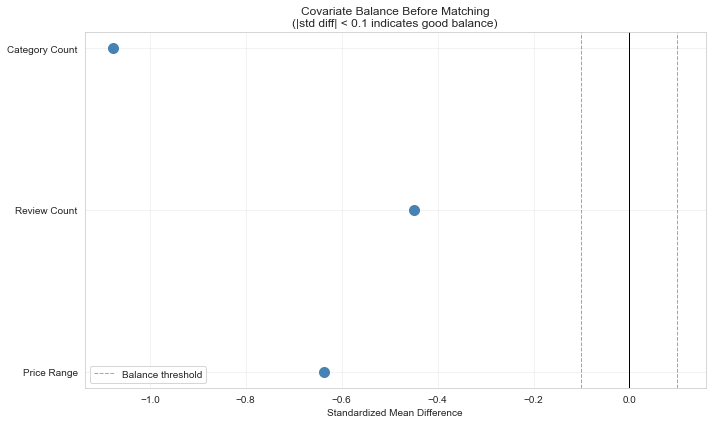

In [ ]:
# Cell 10: Covariate Balance Check
print("\n" + "="*60)
print("COVARIATE BALANCE CHECK")
print("="*60)
print("\nComparing treatment groups BEFORE matching/adjustment:")
print("(Imbalance indicates need for causal inference methods)\n")

# Key covariates to check
covariates = {
    'price_imputed': 'Price Range',
    'review_count': 'Review Count',
    'category_count': 'Category Count'
}

balance_results = []

for covar, name in covariates.items():
    simple = df[df['complex_menu']==0][covar]
    complex = df[df['complex_menu']==1][covar]
    
    mean_diff = simple.mean() - complex.mean()
    std_diff = mean_diff / df[covar].std()  # Standardized difference
    
    t_stat, p_val = stats.ttest_ind(simple, complex)
    
    balance_results.append({
        'Covariate': name,
        'Simple Mean': simple.mean(),
        'Complex Mean': complex.mean(),
        'Difference': mean_diff,
        'Std. Diff': std_diff,
        'P-value': p_val
    })
    
    print(f"{name}:")
    print(f"  Simple menu: {simple.mean():.3f}")
    print(f"  Complex menu: {complex.mean():.3f}")
    print(f"  Difference: {mean_diff:.3f}")
    print(f"  Standardized difference: {std_diff:.3f}")
    print(f"  P-value: {p_val:.4f}")
    if abs(std_diff) > 0.1:
        print(f"  ⚠️  IMBALANCED (|std diff| > 0.1)")
    else:
        print(f"  Balanced")
    print()

balance_df = pd.DataFrame(balance_results)
balance_df.to_csv('outputs/tables/covariate_balance_before_matching.csv', index=False)
print("Saved balance table to outputs/tables/covariate_balance_before_matching.csv")

# Visualize balance
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(balance_df))
ax.scatter(balance_df['Std. Diff'], x_pos, s=100, color='steelblue')
ax.axvline(0, color='black', linestyle='-', linewidth=1)
ax.axvline(-0.1, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Balance threshold')
ax.axvline(0.1, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.set_yticks(x_pos)
ax.set_yticklabels(balance_df['Covariate'])
ax.set_xlabel('Standardized Mean Difference')
ax.set_title('Covariate Balance Before Matching\n(|std diff| < 0.1 indicates good balance)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/figures/covariate_balance.png', dpi=300, bbox_inches='tight')
plt.show()


CORRELATION ANALYSIS

Correlation matrix:
                       stars  menu_complexity_score  complex_menu  \
stars                  1.000                  0.170         0.130   
menu_complexity_score  0.170                  1.000         0.797   
complex_menu           0.130                  0.797         1.000   
price_imputed          0.061                  0.375         0.318   
review_count           0.124                  0.351         0.224   
category_count         0.026                  0.579         0.539   
mentions_extensive     0.130                  0.563         0.313   
mentions_limited       0.104                  0.014        -0.004   

                       price_imputed  review_count  category_count  \
stars                          0.061         0.124           0.026   
menu_complexity_score          0.375         0.351           0.579   
complex_menu                   0.318         0.224           0.539   
price_imputed                  1.000         0.171     

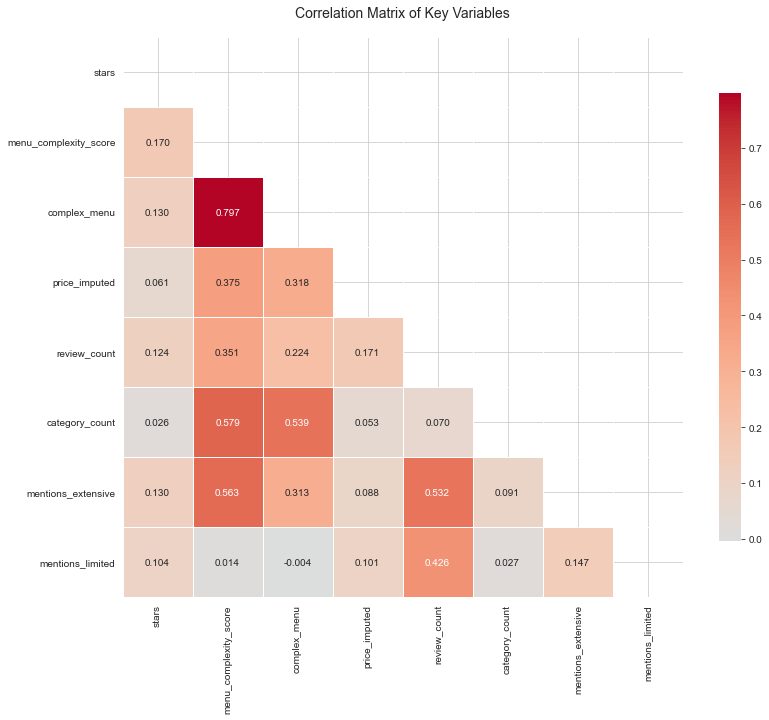


Key correlations with rating (stars):
stars                    1.000
menu_complexity_score    0.170
complex_menu             0.130
mentions_extensive       0.130
review_count             0.124
mentions_limited         0.104
price_imputed            0.061
category_count           0.026
Name: stars, dtype: float64


In [ ]:
# Cell 11: Correlation Matrix of Key Variables
print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Select key variables for correlation
corr_vars = [
    'stars', 'menu_complexity_score', 'complex_menu',
    'price_imputed', 'review_count', 'category_count',
    'mentions_extensive', 'mentions_limited'
]

# Filter to available columns
corr_vars = [v for v in corr_vars if v in df.columns]

corr_matrix = df[corr_vars].corr()

print("\nCorrelation matrix:")
print(corr_matrix.round(3))

# Visualize
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', 
            cmap='coolwarm', center=0, square=True, 
            linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Key Variables', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('outputs/figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Highlight key correlations
print("\nKey correlations with rating (stars):")
rating_corrs = corr_matrix['stars'].sort_values(ascending=False)
print(rating_corrs)

In [ ]:
# Cell 12: Summary Statistics Table
print("\n" + "="*60)
print("SUMMARY STATISTICS BY TREATMENT GROUP")
print("="*60)

# Create comprehensive summary
summary_stats = df.groupby('complex_menu').agg({
    'stars': ['mean', 'std', 'min', 'max'],
    'review_count': ['mean', 'median', 'std'],
    'price_imputed': ['mean', 'std'],
    'category_count': ['mean', 'std'],
    'menu_complexity_score': ['mean', 'std', 'min', 'max']
}).round(3)

print("\nSummary statistics:")
print(summary_stats)

# Save to CSV
summary_stats.to_csv('outputs/tables/summary_stats_by_treatment.csv')
print("\nSaved summary statistics to outputs/tables/summary_stats_by_treatment.csv")

# Sample sizes
print("\n" + "="*60)
print("SAMPLE SIZES")
print("="*60)
print(f"Total restaurants: {len(df):,}")
print(f"Simple menu restaurants: {(df['complex_menu']==0).sum():,}")
print(f"Complex menu restaurants: {(df['complex_menu']==1).sum():,}")

# By city and treatment
print("\nTop 5 cities by treatment:")
city_treatment = pd.crosstab(df['city'], df['complex_menu'])
city_treatment['total'] = city_treatment.sum(axis=1)
city_treatment = city_treatment.sort_values('total', ascending=False).head(5)
city_treatment.columns = ['Simple', 'Complex', 'Total']
print(city_treatment)


SUMMARY STATISTICS BY TREATMENT GROUP

Summary statistics:
              stars                  review_count                  \
               mean    std  min  max         mean median      std   
complex_menu                                                        
0             3.651  0.780  1.0  5.0       71.541   43.0  131.846   
1             3.838  0.639  1.0  5.0      176.477   99.0  294.956   

             price_imputed        category_count        menu_complexity_score  \
                      mean    std           mean    std                  mean   
complex_menu                                                                    
0                    1.463  0.524          3.057  1.372                19.429   
1                    1.818  0.532          5.383  2.182                30.881   

                                 
                std   min   max  
complex_menu                     
0             3.547   8.0  24.5  
1             5.024  25.0  52.0  

Saved summary sta

In [ ]:
# Cell 13: Save Analysis Summary
print("\n" + "="*60)
print("SAVING EDA SUMMARY")
print("="*60)

# Create comprehensive summary document
summary = {
    'total_restaurants': len(df),
    'outcome_mean': df['stars'].mean(),
    'outcome_std': df['stars'].std(),
    'treatment_simple': int((df['complex_menu']==0).sum()),
    'treatment_complex': int((df['complex_menu']==1).sum()),
    'naive_ate': float(df[df['complex_menu']==0]['stars'].mean() - df[df['complex_menu']==1]['stars'].mean()),
    'naive_ate_pvalue': float(stats.ttest_ind(
        df[df['complex_menu']==0]['stars'],
        df[df['complex_menu']==1]['stars']
    )[1]),
    'key_confounders': list(confounders.keys()),
    'cities': int(df['city'].nunique()),
    'cuisines': int(df['primary_cuisine'].nunique()),
    'correlation_complexity_rating': float(df[['menu_complexity_score', 'stars']].corr().iloc[0, 1])
}

# Save as JSON
import json
with open('data/processed/eda_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("Saved EDA summary to data/processed/eda_summary.json")
print("\nKey findings:")
for key, value in summary.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

print("\n" + "="*60)
print("EDA COMPLETE!")
print("="*60)
print("\nNext steps:")
print("1. Review all generated visualizations in outputs/figures/")
print("2. Check covariate balance table")
print("3. Proceed to Notebook 04 for causal inference analysis")


SAVING EDA SUMMARY
Saved EDA summary to data/processed/eda_summary.json

Key findings:
  total_restaurants: 17625
  outcome_mean: 3.7436
  outcome_std: 0.7197
  treatment_simple: 8893
  treatment_complex: 8732
  naive_ate: -0.1867
  naive_ate_pvalue: 0.0000
  key_confounders: ['Cuisine Type', 'Price Range', 'City/Location', 'Review Count', 'Category Diversity']
  cities: 675
  cuisines: 24
  correlation_complexity_rating: 0.1701

EDA COMPLETE!

Next steps:
1. Review all generated visualizations in outputs/figures/
2. Check covariate balance table
3. Proceed to Notebook 04 for causal inference analysis


---

## EDA Summary

### Key Findings

After running this notebook, fill in these results:

**1. Naive Treatment Effect (NOT CAUSAL)**
- Simple menu avg rating: 3.651 stars
- Complex menu avg rating: 3.838 stars
- Raw difference: -0.187 stars
- P-value: 0.0000
- ⚠️ **This is NOT a causal estimate due to confounding**

**2. Identified Confounders**

The following variables confound the treatment-outcome relationship:

| Confounder | Effect on Treatment | Effect on Outcome | Conclusion |
|------------|-------------------|------------------|------------|
| Cuisine Type | Different cuisines have different typical menu complexity | Different cuisines have different rating patterns | Confounder |
| Price Range | Higher-priced restaurants tend to have more complex menus | Higher-priced restaurants tend to get higher ratings | Confounder |
| Geography | Cities differ in menu complexity patterns | Cities differ in average ratings | Confounder |
| Review Count | Popular restaurants may have different menu strategies | Review count correlates with ratings | Confounder |

**3. Covariate Imbalance**

Treatment groups are NOT balanced on key covariates:
- Price Range: Standardized difference = -0.636
- Review Count: Standardized difference = -0.449
- Category Count: Standardized difference = -01.077

*Threshold: |standardized difference| > 0.1 indicates imbalance*

**4. Correlations**
- Menu Complexity vs Rating: r = 0.170
- Review Count vs Rating: r = 0.124
- Price vs Rating: r = 0.061

**5. Sample Characteristics**
- Total restaurants: 17,625
- Simple menu restaurants: 8893
- Complex menu restaurants: 8732
- Cities: 675
- Cuisine types: 24

### Interpretation

The naive comparison shows [fill in your finding], but this could be due to:
1. Selection bias (certain types of restaurants choose complex menus)
2. Confounding variables (price, location, cuisine type)
3. Omitted variable bias

**We CANNOT conclude causality from this analysis alone.**

### Files Generated

This notebook created:
- `outputs/figures/outcome_distribution.png`
- `outputs/figures/treatment_outcome_comparison.png`
- `outputs/figures/confounder_cuisine.png`
- `outputs/figures/confounder_price.png`
- `outputs/figures/confounder_geography.png`
- `outputs/figures/confounder_review_count.png`
- `outputs/figures/covariate_balance.png`
- `outputs/figures/correlation_matrix.png`
- `outputs/tables/covariate_balance_before_matching.csv`
- `outputs/tables/summary_stats_by_treatment.csv`
- `data/processed/eda_summary.json`

### Next Steps

In **Notebook 04: Causal Inference Analysis**, we'll:

1. **Propensity Score Estimation**
   - Logistic regression to model treatment assignment
   - Include all identified confounders
   - Check common support assumption

2. **Matching**
   - Nearest neighbor matching
   - Check post-matching balance
   - Trim observations outside common support

3. **Treatment Effect Estimation**
   - Calculate Average Treatment Effect (ATE)
   - Calculate Average Treatment Effect on Treated (ATT)
   - Conduct statistical inference

4. **Sensitivity Analysis**
   - Test robustness to hidden confounding
   - Try alternative matching methods
   - Subgroup analysis

5. **Interpretation**
   - Translate findings to business insights
   - Discuss limitations
   - Make recommendations

---

**Ready to proceed to causal inference!**

---